In [1]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import itertools



In [2]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [3]:
#concatenate path to name of each file and store in array for reading in data
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)

In [4]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [5]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [6]:
def update_stim_code_event_ids(epoch_object):
    keys_to_delete = [x for x in epoch_object.event_id if 'stim' in x]
    
    for key in keys_to_delete:
        if key in epoch_object.event_id.keys():
            del epoch_object.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch_object.event_id[key] = new_stim_code_event_ids[key]
    return epoch_object

In [7]:
epochs = update_stim_code_event_ids(epoch)
epochs.event_id

{'b-f1-pic': 8,
 'b-f1-snd': 11,
 'b-f1-spk': 5,
 'b-f1-wrd': 2,
 'b-f2-pic': 7,
 'b-f2-snd': 10,
 'b-f2-spk': 4,
 'b-f2-wrd': 1,
 'b-tg-pic': 9,
 'b-tg-snd': 12,
 'b-tg-spk': 6,
 'b-tg-wrd': 3,
 'congruent': 133,
 'correct': 129,
 'f-f1-pic': 20,
 'f-f1-snd': 23,
 'f-f1-spk': 17,
 'f-f1-wrd': 14,
 'f-f2-pic': 19,
 'f-f2-snd': 22,
 'f-f2-spk': 16,
 'f-f2-wrd': 13,
 'f-tg-pic': 21,
 'f-tg-snd': 24,
 'f-tg-spk': 18,
 'f-tg-wrd': 15,
 'f_baby': 155,
 'f_bell': 156,
 'f_bird': 157,
 'f_burp': 158,
 'f_dog': 159,
 'f_drum': 160,
 'f_knock': 161,
 'f_laugh': 162,
 'f_phone': 163,
 'f_train': 164,
 'f_water': 165,
 'incongruent': 134,
 'incorrect': 130,
 'left_button': 131,
 'right_button': 132,
 't_baby': 135,
 't_bell': 136,
 't_bird': 137,
 't_burp': 138,
 't_dog': 139,
 't_drum': 140,
 't_knock': 141,
 't_laugh': 142,
 't_phone': 143,
 't_train': 144,
 't_water': 145,
 'trail_start': 31}

In [20]:
filtered_epoch = epochs[(epochs.events[:,-1] >= 7) & (epochs.events[:,-1] <= 9) | 
                        (epochs.events[:,-1] >= 19) & (epochs.events[:,-1] <= 21) |
                       (epochs.events[:,-1] >= 10) & (epochs.events[:,-1] <= 12) |
                       (epochs.events[:,-1] >= 22) & (epochs.events[:,-1] <= 24)]

In [21]:
filtered_epoch.event_id

{'b-f1-pic': 8,
 'b-f1-snd': 11,
 'b-f2-pic': 7,
 'b-f2-snd': 10,
 'b-tg-pic': 9,
 'b-tg-snd': 12,
 'f-f1-pic': 20,
 'f-f1-snd': 23,
 'f-f2-pic': 19,
 'f-f2-snd': 22,
 'f-tg-pic': 21,
 'f-tg-snd': 24}

In [23]:
#0 for visual and 1 for audio
test = filtered_epoch

for i in range(0,980):
    if test.events[i][-1] in (7,8, 9, 19, 20, 21):
        test.events[i][-1] = 0
    elif test.events[i][-1] in (10, 11, 12, 22, 23, 24):
        test.events[i][-1] = 1

In [24]:
test.events

array([[  2593,      0,      0],
       [  2847,      0,      0],
       [  3682,      0,      0],
       ...,
       [655357,      0,      0],
       [658221,      0,      0],
       [658755,      0,      0]])

In [25]:
dataXX = test.get_data()
eventsYY = test.events[:,-1]

clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    LDA())

#cross validation
cv = StratifiedKFold(n_splits = 10, shuffle=True)
preds = np.empty(len(eventsYY))
scoresss = []
for train,test in cv.split(dataXX,eventsYY):
    clf.fit(dataXX[train],eventsYY[train])
    preds[test] = clf.predict(dataXX[test])
    scoresss.append(clf.score(dataXX[test],eventsYY[test]))

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/anaconda3/lib/python3.6/site-packages/sklearn

In [26]:
print("mean classification score", np.mean(scoresss))


mean classification score 0.7163265306122449


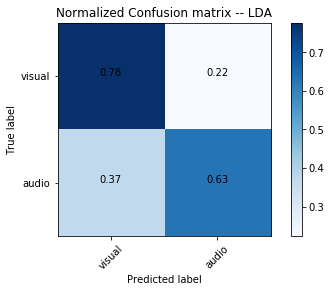

In [27]:
target_names = [ 'visual', 'audio']
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(eventsYY,preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- LDA')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

fmt = '.2f'
for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j],fmt),
                 horizontalalignment="center",
                 color="black")
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()